In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tableone import TableOne
from statsmodels.api import OLS
from statsmodels.stats import proportion
from patsy import dmatrices
from scipy.stats import ttest_1samp
wd = "S:/Laura/BDC/Projects/Viral Shah/ADA 2022/"
# wd = "/Users/timvigers/Dropbox/Work/Viral Shah/ADA 2022/"

## Data
- Participants with HbA1c >= 6.5 were excluded from Kaan's CGM dataset. The remaining participants were combined with publicly available data on non-diabetics from the JAEB (https://public.jaeb.org/datasets/diabetes).
- For each participant, mean blood glucose was calculated from CGM data, and GMI calculated according to the standard equation (3.31 + 0.02392 * MBG). 
- GMI was compared to lab HbA1c, and a new GMI regression equation was estimated for this population. 

In [2]:
# Import Kaan's data
df = pd.read_csv(wd + "Data_Clean/analysis_data.csv",usecols=["ID","Age","14 Day Mean","HbA1c"])
# Only HbA1c < 6.5
df = df[df["HbA1c"] < 6.5]
df.columns = ["PtID","AgeAsOfEnrollDt","HbA1c","MBG"]
df["MBG"] = [round(m,2) for m in df["MBG"]]
df["Cohort"] = "BDC"
# Add JAEB data
jaeb_cgm = pd.read_csv(wd + "Data_Raw/CGMND/NonDiabDeviceCGM.csv")
jaeb_cgm = jaeb_cgm[jaeb_cgm["RecordType"] == "CGM"]
# Split by ID
dataframes = []
for _, d in jaeb_cgm.groupby(["PtID"]):
    dataframes.append(d)
# Calculate mean glucose for each participant
mean_bgs = {"PtID":[],"MBG":[]}
for d in dataframes:
    mean_bgs["PtID"].append(d["PtID"].iloc[0])
    mean_bgs["MBG"].append(round(d["Value"].mean(),2))
mean_bgs = pd.DataFrame(mean_bgs)
# Exclude patients (per Stephanie DuBose)
exclude = pd.read_csv(wd+"Data_Raw/List of Excluded Pts.csv")
idx = ~mean_bgs['PtID'].isin(exclude['PtID'])
mean_bgs = mean_bgs[idx]
# Add HbA1c
jaeb_a1c = pd.read_csv(wd + "Data_Raw/CGMND/NonDiabSampleResults.csv")
jaeb_a1c = jaeb_a1c[jaeb_a1c["Analyte"] == "HBA1C"]
jaeb_a1c = jaeb_a1c[["PtID","Value"]]
jaeb_a1c.columns = ["PtID","HbA1c"]
jaeb_a1c["PtID"] = [str(p) for p in jaeb_a1c["PtID"]]
mean_bgs["PtID"] = [str(p) for p in mean_bgs["PtID"]]
mean_bgs = mean_bgs.merge(jaeb_a1c,on = "PtID")
# Age
jaeb_age = pd.read_csv(wd + "Data_Raw/CGMND/NonDiabPtRoster.csv",usecols=["PtID","AgeAsOfEnrollDt"])
jaeb_age["PtID"] = [str(p) for p in jaeb_age["PtID"]]
mean_bgs = mean_bgs.merge(jaeb_age,on = "PtID")
mean_bgs = mean_bgs[mean_bgs["HbA1c"] < 6.5]
mean_bgs["Cohort"] = "JAEB"
# Combine
df = pd.concat([df,mean_bgs])
# Calculate GMI
df["GMI"] = [3.31 + 0.02392*m for m in df["MBG"]]
df["Diff"] = df["HbA1c"] - df["GMI"]
df.reset_index(inplace=True,drop=True)
# Write
df.to_csv(wd + 'Data_Clean/combined_data.csv',index=False)
# Split by HbA1c < 5.7 and 5.7 - 6.5
nondiab = df[df['HbA1c'] < 5.7]
prediab = df[(df['HbA1c'] >= 5.7) & (df['HbA1c'] < 6.5)]
# Reindex
nondiab.reset_index(inplace=True,drop=True)
prediab.reset_index(inplace=True,drop=True)

In [3]:
TableOne(df,columns=["HbA1c","AgeAsOfEnrollDt"],groupby=["Cohort"])

Grouped by Cohort                                       
                                      Missing      Overall          BDC         JAEB
n                                                      246           93          153
HbA1c, mean (SD)                            0    5.4 (0.5)    5.9 (0.4)    5.1 (0.3)
AgeAsOfEnrollDt, mean (SD)                  0  34.5 (18.7)  40.6 (12.6)  30.7 (20.7)

# HbA1c < 5.7

## Mean Glucose and HbA1c
Red line indicates GMI regression line.

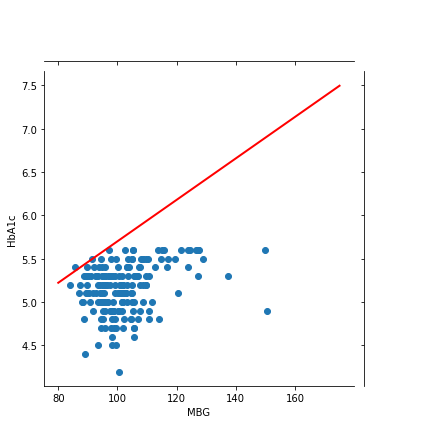

In [4]:
grid = sns.JointGrid(x=nondiab["MBG"],y=nondiab["HbA1c"])
grid.plot_joint(plt.scatter)
plt.plot([80,175],[5.2236,7.496], linewidth=2, color = "r");

## Differences between HbA1c and GMI

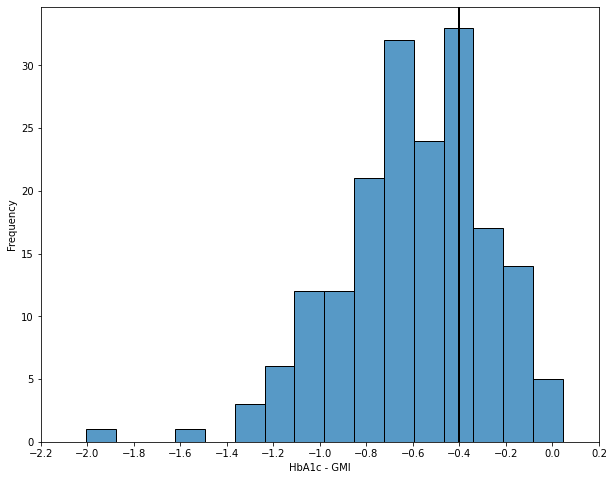

In [25]:
# bin settings
min_val = nondiab.Diff.min()
max_val = nondiab.Diff.max()
val_width = max_val - min_val
n_bins = 16 # stay consistent w original plot
bin_width = val_width/n_bins

# plot tinkering
plt.figure(figsize=(10,8))
sns.histplot(data=nondiab, x="Diff")
plt.xlabel("HbA1c - GMI");
plt.ylabel("Frequency");
# plt.xticks(np.arange(min_val+bin_width/2, max_val+bin_width/2, bin_width*3)); # bin centered ticks
plt.xticks(np.arange(-2.2, 0.2, 0.2)); # comment this out for nicer, but uncentered ticks
plt.axvline(-0.4, linewidth = 2, color = "black") # vertical line at -0.4
# save figure
plt.savefig(wd + "Reports/figure_under_5.7_axisticks.jpg")
plt.show()

In [22]:
t = ttest_1samp(nondiab["Diff"],popmean = 0)
t.pvalue
#nondiab["Diff"].mean()

5.967094111311294e-61

The differences between HbA1c and GMI were largely negative, suggesting that the standard GMI equation overestimates HbA1c in this cohort. On average, GMI was 0.52% higher, and this was significantly different from 0 (p < 0.0001).

## Regression Results

In [7]:
outcome,predictors = dmatrices("HbA1c ~ MBG",data = nondiab)
reg = OLS(outcome,predictors).fit()

In [8]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  HbA1c   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     19.71
Date:                Wed, 07 Sep 2022   Prob (F-statistic):           1.57e-05
Time:                        15:04:42   Log-Likelihood:                -18.014
No. Observations:                 181   AIC:                             40.03
Df Residuals:                     179   BIC:                             46.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3193      0.190     22.694      0.000       3.944       4.695
MBG            0.0082      0.002      4.440      0.000       0.005       0.012
==============================================================================
Omnibus:                       13.667   Durbin-Watson:                   1.521
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.884
Skew:                          -0.699   Prob(JB):                     0.000586
Kurtosis:                       3.132   Cond. No.                         979.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on this dataset, the regression equation for GMI would be:

GMI = 3.4551 + 0.0180 * MBG

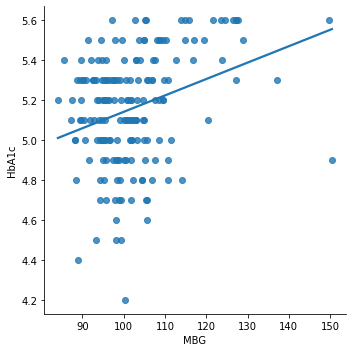

In [9]:
sns.lmplot(x="MBG",y="HbA1c",data=nondiab,ci=None);

# HbA1c 5.7 - 6.5
## Mean Glucose and HbA1c
Red line indicates GMI regression line.

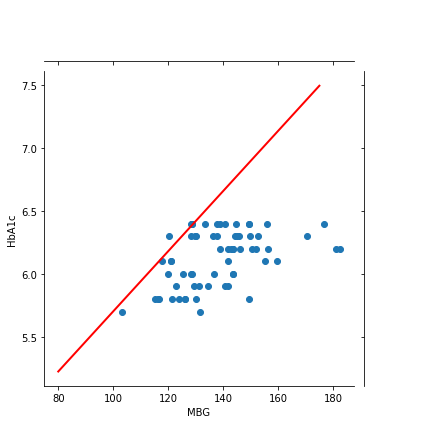

In [10]:
grid = sns.JointGrid(x=prediab["MBG"],y=prediab["HbA1c"])
grid.plot_joint(plt.scatter)
plt.plot([80,175],[5.2236,7.496], linewidth=2, color = "r");

## Differences between HbA1c and GMI

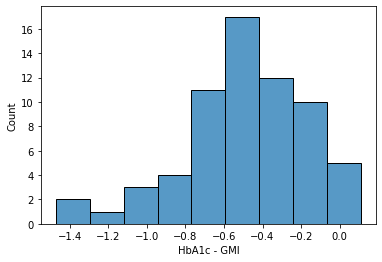

In [11]:
sns.histplot(data=prediab, x="Diff")
plt.xlabel("HbA1c - GMI");

In [12]:
plt.savefig(wd + "Reports/figure.png")

<Figure size 432x288 with 0 Axes>

In [13]:
t = ttest_1samp(prediab["Diff"],popmean = 0)
t.pvalue
#prediab["Diff"].mean()

1.3006313817957117e-17

The differences between HbA1c and GMI were largely negative, suggesting that the standard GMI equation overestimates HbA1c in this cohort. On average, GMI was 0.5% higher, and this was significantly different from 0 (p < 0.0001).

## Regression Results

In [14]:
outcome,predictors = dmatrices("HbA1c ~ MBG",data = prediab)
reg = OLS(outcome,predictors).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  HbA1c   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     16.77
Date:                Wed, 07 Sep 2022   Prob (F-statistic):           0.000122
Time:                        15:04:43   Log-Likelihood:                 14.701
No. Observations:                  65   AIC:                            -25.40
Df Residuals:                      63   BIC:                            -21.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2418      0.217     24.121      0.000       4.808       5.676
MBG            0.0064      0.002      4.095      0.000       0.003       0.010
==============================================================================
Omnibus:                        9.484   Durbin-Watson:                   1.645
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                2.990
Skew:                           0.021   Prob(JB):                        0.224
Kurtosis:                       1.950   Cond. No.                     1.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

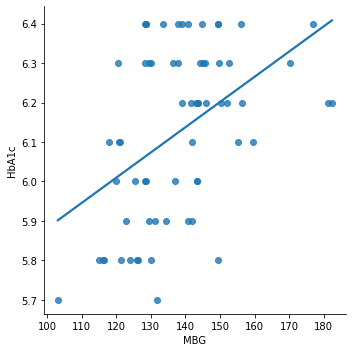

In [15]:
sns.lmplot(x="MBG",y="HbA1c",data=prediab,ci=None);